In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
RUN_ID = 86505

df_conditions = pd.read_csv(f'./results/{RUN_ID}/conditions.csv')
df_conditions_melted = df_conditions.melt(id_vars='generation', var_name='condition', value_name='value')

df_actions = pd.read_csv(f'./results/{RUN_ID}/actions.csv')
df_actions_melted = df_actions.melt(id_vars='generation', var_name='action', value_name='value')

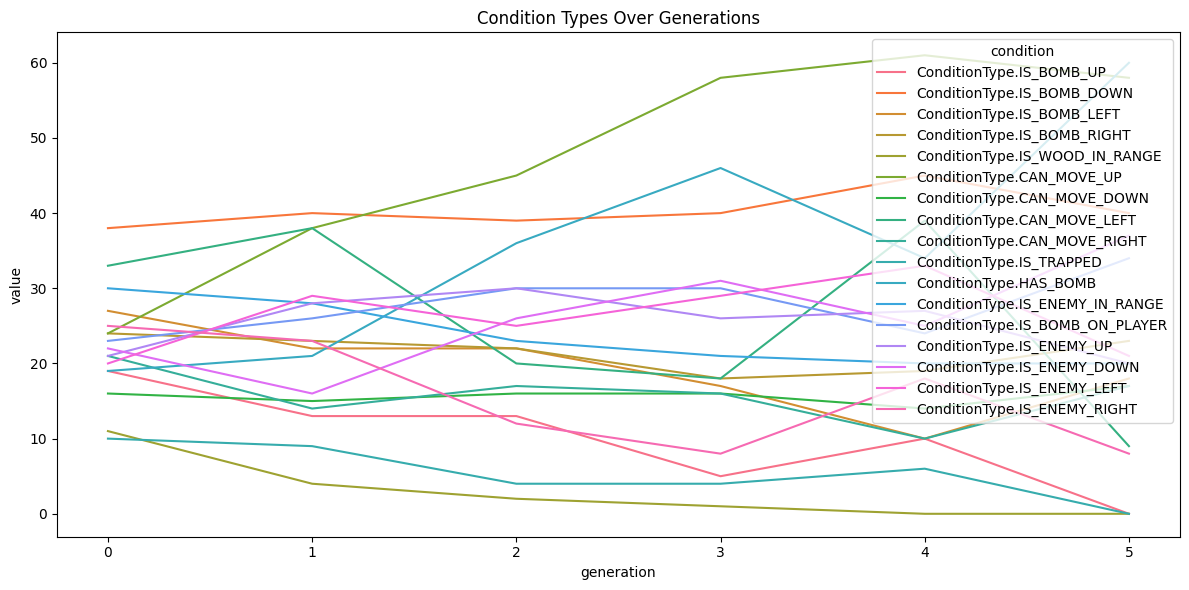

In [11]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_conditions_melted, x='generation', y='value', hue='condition')
plt.title("Condition Types Over Generations")
plt.tight_layout()
plt.show()


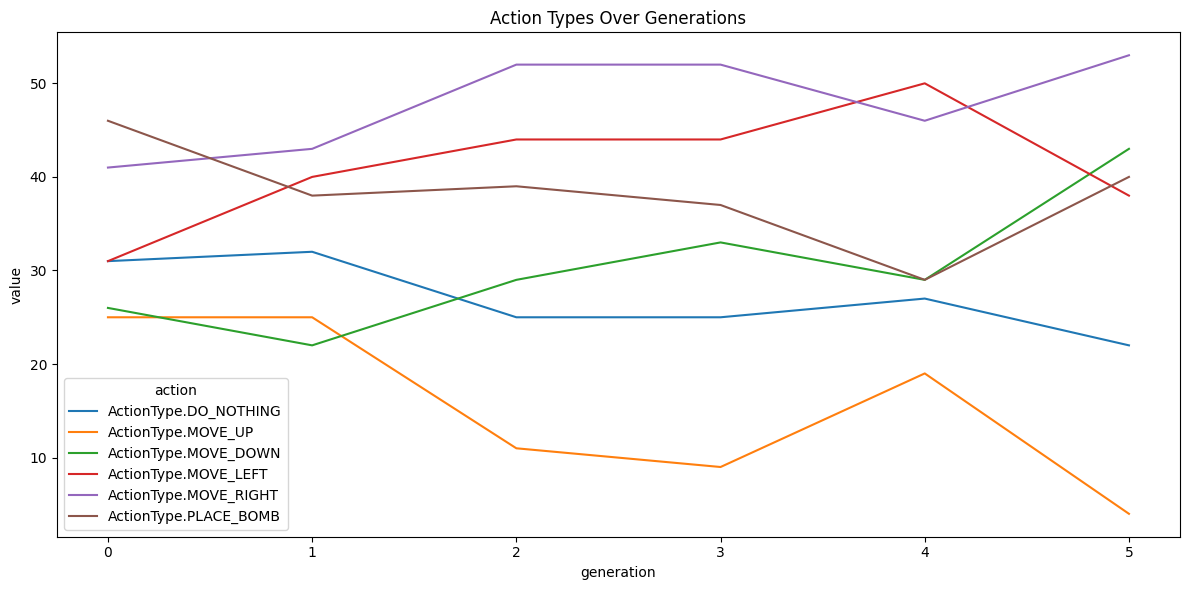

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_actions_melted, x='generation', y='value', hue='action')
plt.title("Action Types Over Generations")
plt.tight_layout()
plt.show()